In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


import warnings
warnings.filterwarnings("ignore")
from analysis_functions import *

In [2]:
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 1                 ## value of resampling
period = int(10 * sf / re_sf)
period_resting = period *50
N_SHUFFLINGS = 50
colorcodes = ['Greys','PuBu', 'YlOrRd','Reds','Blues','Oranges','Greens']


In [3]:
mouse = 56165 ### mouse number id
session_now = 1

file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/transformation_maps/'

output_path = os.environ['PROJECT_DIR'] +'neural_analysis/data/lda_prediction/'

objects_position_file = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/occupied_corners/' + 'mouse_'+f'{mouse}'+'_session_'+f'{session_now}'+'.npy'
occupied_corners = np.load(objects_position_file)

In [4]:
task,colapse_behaviour,object_fixed,fixed,labels,colornames = mouse_properties(mouse = mouse, session_now = session_now)

activity_list,timeline_list,behaviour_list,corners_list,parameters_time,parameters_list,parameters_list2, speed_list, day_list, tracking_list_day = load_data(mouse, session_now,decoding_v, motion_correction_v, alignment_v, equalization_v,source_extraction_v,component_evaluation_v, re_sf,file_directory, timeline_file_dir, behaviour_dir, behaviour_dir_parameters, tracking_dir, objects_dir)
activity_list_trial,timeline_list_trial,behaviour_list_trial,corners_list_trial,parameters_time_trial,parameters_list_trial,parameters_list2_trial, speed_list_trial,trial_list,tracking_list_trial = load_data_trial(mouse, session_now,decoding_v, motion_correction_v, alignment_v, equalization_v,source_extraction_v,component_evaluation_v, re_sf,file_directory, timeline_file_dir, behaviour_dir, behaviour_dir_parameters, tracking_dir, objects_dir)
#activity_list_trial, activity_list_trial_rest,timeline_list_trial,behaviour_list_trial,corners_list_trial,parameters_time_trial,parameters_list_trial,parameters_list2_trial, speed_list_trial,trial_list,tracking_list_trial = load_data_trial_rest(mouse, session_now,decoding_v, motion_correction_v, alignment_v, equalization_v,source_extraction_v,component_evaluation_v, re_sf,file_directory, timeline_file_dir, behaviour_dir, behaviour_dir_parameters, tracking_dir, objects_dir)

LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR
neural shape =  (195, 32368) beh shape(32368,)
neural shape =  (448, 30592) beh shape(30592,)
neural shape =  (322, 31977) beh shape(31977,)
neural shape =  (397, 30905) beh shape(30905,)
LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR
neural shape =  (195, 32368) beh shape(32368,)
neural shape =  (195, 32368) beh shape(32368,)
neural shape =  (195, 32368) beh shape(32368,)
neural shape =  (195, 32368) beh shape(32368,)
neural shape =  (195, 32368) beh shape(32368,)
neural shape =  (448, 30592) beh shape(30592,)
neural shape =  (448, 30592) beh shape(30592,)
neural shape =  (448, 30592) beh shape(30592,)
neural shape =  (448, 30592) beh shape(30592,)
neural shape =  (448, 30592) beh shape(30592,)
neural shape =  (322, 31977) beh shape(31977,)
neural shape =  (322, 31977) beh shape(31977,)
neural shape =  (322, 31977) beh shape(31977,)
neural shape =  (322, 31977) beh shape(31977,

In [8]:
    #def cca_neural(activity_list, behaviour_list,trial_list):
    
    cca_components = activity_list[0].shape[0]
    cca = CCA(n_components=cca_components)
    
    trial_vector  = [1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4]

    #embedding = MDS(n_components=3)
    trial_list_new = np.zeros_like(trial_list)
    for day1 in range(len(trial_list)):
        for day2 in range(len(trial_list)):
            if trial_list[day1] and trial_list[day2]:
                trial_list_new[day1] = trial_list[day1]
                if activity_list[day1].shape[1] == behaviour_list[day1].shape[0] and trial_vector[day1] == trial_vector[day2]:                    
                    X1 = activity_list[day1].T
                    y1 = behaviour_list[day1]
                    X2 = activity_list[day2].T
                    y2 = behaviour_list[day2]
                    
                    cca_transformed = cca.fit(X1.T, X2.T)
                    #X_cc_transformed = embedding.fit_transform(cca_transformed.T)    
                    
#             else:
#         else:
#             continue
    
    #    return score_matrix


KeyboardInterrupt: 

In [25]:
X1 = activity_list_trial[0].T
y1 = behaviour_list_trial[0]
X2 = activity_list_trial[1].T
y2 = behaviour_list_trial[1]
                    
cca_transformed = cca.fit(X1.T, X2.T).transform(X1)

ValueError: operands could not be broadcast together with shapes (3281,195) (3281,) (3281,195) 

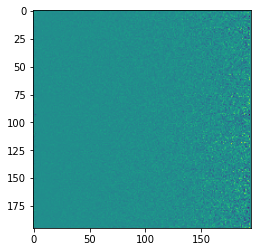

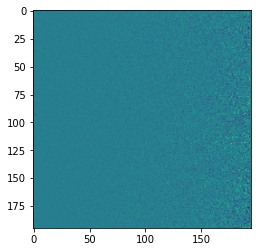

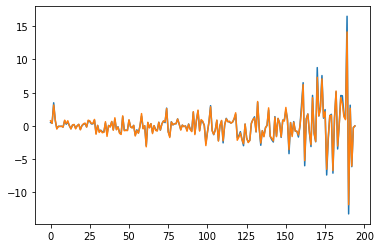